**Task 0: Data Analysis**

Ideas for data analysis:

How often does each label appear in the data?
- Separate train/valid/test splits
How long are the questions and answers?
- Can/should/must we truncate?

What words appear most in ...
- correct answers?
- wrong answers?

→ Are there annotation artifacts in this dataset?

In [29]:
from datasets import load_dataset
train = load_dataset("ai2_arc", 'ARC-Easy', split='train').to_pandas()
test = load_dataset("ai2_arc", 'ARC-Easy', split='test').to_pandas()
dev = load_dataset("ai2_arc", 'ARC-Easy', split='validation').to_pandas()

In [30]:
train.answerKey.unique()

array(['B', 'D', 'A', '3', 'C', '1', '2', '4', 'E'], dtype=object)

In [31]:
display(f'Train: {train.shape}, Dev: {dev.shape}, Test: {test.shape}, {train.columns}')
train.head(1)

"Train: (2251, 4), Dev: (570, 4), Test: (2376, 4), Index(['id', 'question', 'choices', 'answerKey'], dtype='object')"

,id,question,choices,answerKey
0,Mercury_7220990,Which factor will most likely cause a person t...,{'text': ['a leg muscle relaxing after exercis...,B


| Field Name            | Description                                                  |
|-----------------------|--------------------------------------------------------------|
| questionID            | Unique identifier for the question.                           |
| originalQuestionID    | Legacy ID used within AI2.                                    |
| totalPossiblePoint    | The point value of the question for grading purposes.          |
| AnswerKey             | The letter signifying the correct answer option for the question. (A,B,C,D,E,1,2,3,4)|
| isMultipleChoice      | 1 indicates the question is multiple choice.                   |
| includesDiagram       | 0 indicates the question does not include a diagram.           |
| examName              | The name of the source exam for these questions.                |
| schoolGrade           | The intended grade level for the question.                     |
| year                  | The year the questions were sourced for AI2.                   |
| question              | The question and its answer options.                           |
| subject               | The question's subject; this is left blank in this data set.   |
| category              | Whether the question is a Train, Dev, or Test question.        |


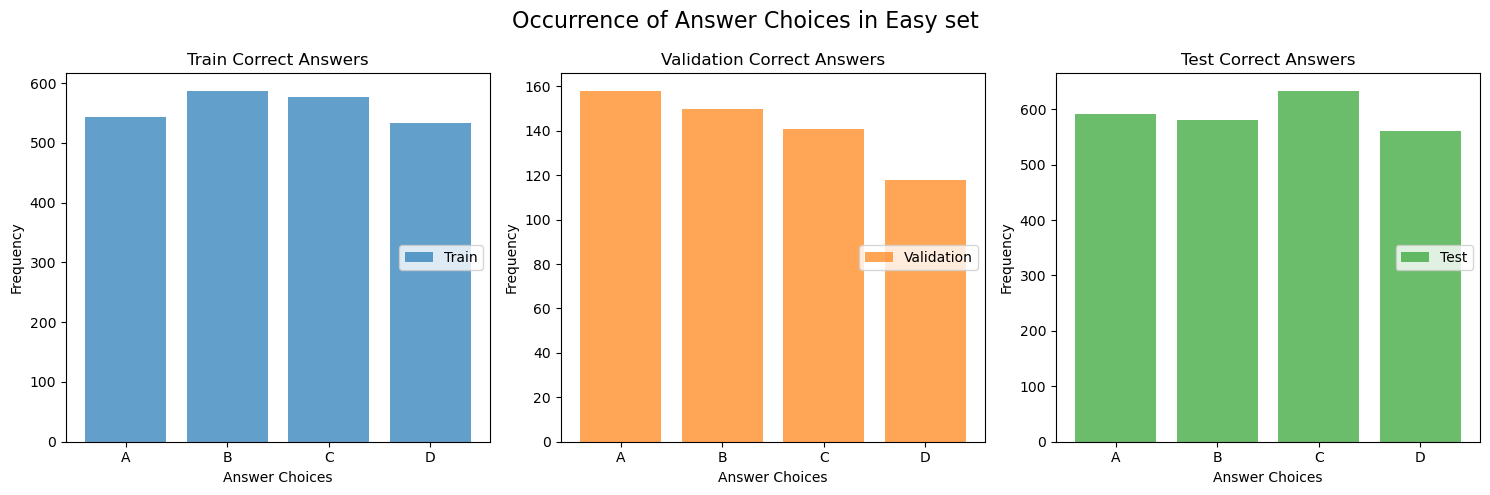

In [67]:
import matplotlib.pyplot as plt

def preprocess(dataframe):
    answer_key_mapping = {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', '1': 'A', '2': 'B', '3': 'C', '4': 'D'}
    df = dataframe.copy()
    df['choices'] = df['choices'].apply(lambda x: x['text'])
    df = df[df['choices'].apply(len) == 4]
    df['answerKey'] = df['answerKey'].replace(answer_key_mapping)
    return(df)
train_df = preprocess(train)
dev_df = preprocess(dev)
test_df = preprocess(test)

small = (15, 5)
big = (15, 10)

def count_answer(df):
    df_answers = df[df['answerKey'].isin(['A', 'B', 'C', 'D'])]
    df_counts = df_answers['answerKey'].value_counts().sort_index()  # Sort the index alphabetically
    return df_counts

train_counts = count_answer(train_df)
dev_counts = count_answer(dev_df)
test_counts = count_answer(test_df)

fig, axes = plt.subplots(1, 3, figsize=small)

def plot_counts(ax, counts, title, color, label, yscale='linear'):
    ax.bar(counts.index, counts.values, alpha=0.7, color=color, label=label)
    ax.set_title(title)
    ax.set_xlabel('Answer Choices' if 'Correct' in title else 'Other Answer Choices')
    ax.set_ylabel('Frequency')
    ax.legend(loc='center right')
    ax.set_yscale(yscale)

plot_counts(axes[0], train_counts, title='Train Correct Answers', color='tab:blue', label='Train')
plot_counts(axes[1], dev_counts, title='Validation Correct Answers', color='tab:orange', label='Validation')
plot_counts(axes[2], test_counts, title='Test Correct Answers', color='tab:green', label='Test')

plt.suptitle('Occurrence of Answer Choices in Easy set', fontsize=16)
plt.tight_layout()
plt.show()


# Topic modeling or sentiment analysis 

In [68]:
import nltk
import gensim
nltk.download('punkt')
nltk.download('stopwords')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/choekyelnyungmartsang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/choekyelnyungmartsang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words = stop_words | {'?', ",", ".", "\'s", "[", "]", "(", ")", "_"}

def preprocess(questions):
    question_text = questions.split('(A)')[0]
    question_text = question_text.split('(1)')[0]
    question_text = nltk.word_tokenize(question_text)
    question_text = [word.lower() for word in question_text]
    question_text = [word for word in question_text if word not in stop_words]
    
    return question_text

processed_questions = [preprocess(q) for q in train_df.question]


In [76]:
bigrams = gensim.models.Phrases(processed_questions, min_count=5, threshold=50)
trigrams = gensim.models.Phrases(bigrams[processed_questions], threshold=50)

bigram_phraser = gensim.models.phrases.Phraser(bigrams)
trigram_phraser = gensim.models.phrases.Phraser(trigrams)

def make_bigrams(questions):
    return [bigram_phraser[doc] for doc in questions]

def make_trigrams(questions):
    return [trigram_phraser[bigram_phraser[doc]] for doc in questions]

data_bigrams = make_bigrams(processed_questions)
# data_bigrams = make_bigrams(processed_questions)
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [77]:
flattened_data = [word for doc in data_bigrams_trigrams for word in doc]
words_with_underscore = [word for word in flattened_data if '_' in word]
print(words_with_underscore)

['best_explains', 'tectonic_plates', 'period_time', 'best_describes', '___', 'best_describes', 'best_describes', 'fe_', '{_2_}', 'o_', '{_3_}', 'agno_', '{_3_}', 'no_', '{_3_}', '{_2_}', '2agno_', '{_3_}', '-_>', 'no_', '{_3_}', '{_2_}', 'best_explains', 'tectonic_plates', 'solar_system', 'greenhouse_gases', 'human_body', 'solar_system', 'human_body', 'best_describes', 'solar_system', 'solar_system', 'solar_system', 'best_describes', 'solar_system', 'renewable_resource', 'take_place', 'digestive_system', 'digestive_system', 'greenhouse_gases', 'chemical_reaction', 'living_organisms', 'solar_system', 'nervous_system', 'nervous_system', 'renewable_resource', 'periodic_table', 'human_body', '___', 'take_place', 'best_explains', 'tectonic_plate', 'tectonic_plate', 'human_body', 'best_describes', 'new_york', 'best_describes', 'best_describes', 'life_cycle', '___', 'learned_behavior', 'best_describes', 'years_ago', 'years_ago', 'best_explains', 'statement_best_explains', 'best_describes', 'b

In [82]:
# create the dictionary and corpus objects that gensim uses for topic modeling
dictionary = gensim.corpora.Dictionary(data_bigrams_trigrams)

# remove words that occur in less than 1 questions, or more than 50% of documents
dictionary.filter_extremes(no_below=2, no_above=0.8)
temp = dictionary[0]  # load the dictionary by calling it once
corpus_bow = [dictionary.doc2bow(question) for question in data_bigrams_trigrams]

model_tfidf = gensim.models.TfidfModel(corpus_bow)
corpus_tfidf = model_tfidf[corpus_bow]
# print(corpus_tfidf[0])
model_lda = gensim.models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=10, random_state=2023, update_every=1, chunksize=100, passes=10, alpha='auto')

In [83]:
model_lda.print_topics(5)

[(2,
  '0.031*"provides" + 0.029*"caused" + 0.022*"disease" + 0.022*"chemical_reaction" + 0.021*"tool" + 0.021*"electrical" + 0.019*"amount" + 0.016*"often" + 0.016*"removing" + 0.015*"experiment"'),
 (5,
  '0.053*"cells" + 0.022*"animal" + 0.018*"day" + 0.016*"moving" + 0.016*"direction" + 0.015*"field" + 0.014*"resource" + 0.014*"responsible" + 0.013*"skin" + 0.013*"night"'),
 (7,
  '0.032*"energy" + 0.022*"food" + 0.020*"atmosphere" + 0.017*"survive" + 0.017*"result" + 0.016*"important" + 0.014*"form" + 0.013*"plant" + 0.013*"cell" + 0.012*"soil"'),
 (4,
  '0.024*"water" + 0.018*"example" + 0.018*"would" + 0.016*"used" + 0.014*"process" + 0.013*"likely" + 0.012*"common" + 0.012*"found" + 0.011*"many" + 0.011*"type"'),
 (3,
  '0.020*"following" + 0.017*"earth" + 0.014*"best" + 0.012*"body" + 0.011*"two" + 0.010*"organisms" + 0.010*"plants" + 0.009*"change" + 0.009*"student" + 0.009*"characteristic"')]

In [84]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(model_lda, corpus_tfidf, dictionary, mds='mmds', R=10)
pyLDAvis.display(lda_display)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [2]:
from datasets import load_dataset
train = load_dataset("ai2_arc", 'ARC-Easy', split='train').to_pandas()
test = load_dataset("ai2_arc", 'ARC-Easy', split='test').to_pandas()
dev = load_dataset("ai2_arc", 'ARC-Easy', split='validation').to_pandas()

# train = load_dataset("ai2_arc", 'ARC-Challenge', split='train').to_pandas()
# test = load_dataset("ai2_arc", 'ARC-Challenge', split='test').to_pandas()
# dev = load_dataset("ai2_arc", 'ARC-Challenge', split='validation').to_pandas()

In [3]:
train.columns

Index(['id', 'question', 'choices', 'answerKey'], dtype='object')

In [4]:
train.choices[0]

{'text': array(['a leg muscle relaxing after exercise',
        'a bacterial population in the bloodstream',
        'several viral particles on the skin',
        'carbohydrates being digested in the stomach'], dtype=object),
 'label': array(['A', 'B', 'C', 'D'], dtype=object)}

In [25]:
from transformers import AutoTokenizer

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_question_lengths = []
validation_question_lengths = []
test_question_lengths = []

for q in train.question:
    tokens = tokenizer.encode(q, add_special_tokens=True)
    train_question_lengths.append(len(tokens))

for q in dev.question:
    tokens = tokenizer.encode(q, add_special_tokens=True)
    validation_question_lengths.append(len(tokens))

for q in test.question:
    tokens = tokenizer.encode(q, add_special_tokens=True)
    test_question_lengths.append(len(tokens))

# print(f'Min: {min(question_lengths)}')
# print(f'Max: {max(question_lengths)}')

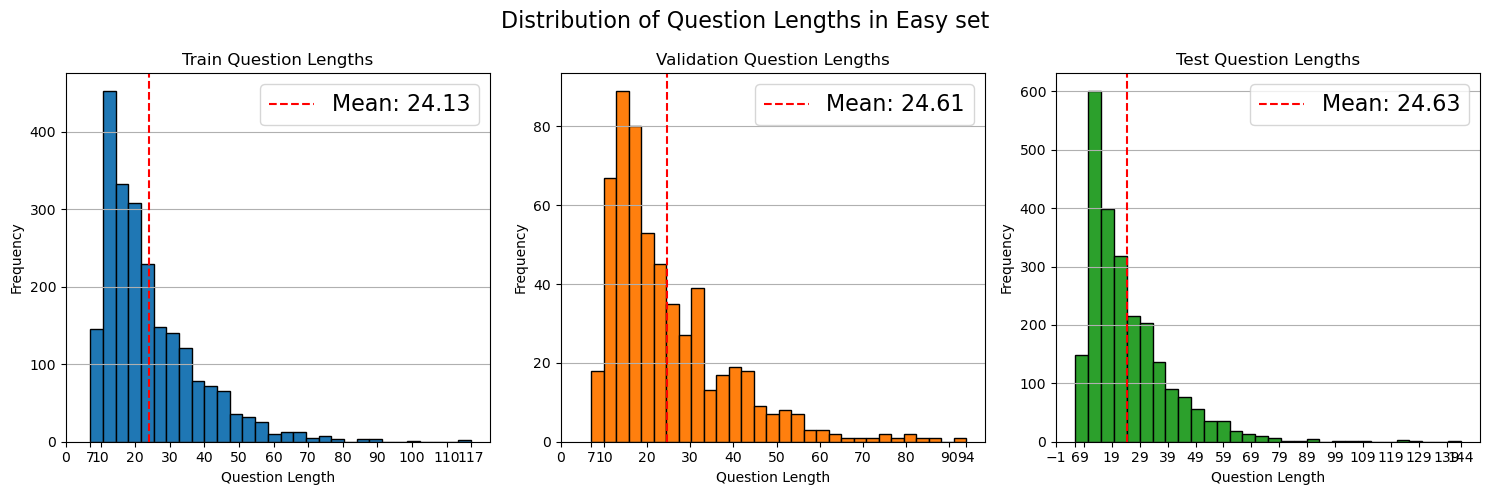

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

datasets = [train_question_lengths, validation_question_lengths, test_question_lengths]
titles = ['Train', 'Validation', 'Test']
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, ax in enumerate(axs):
    ax.hist(datasets[i], bins=30, color=colors[i], edgecolor='black')
    ax.set_xlabel('Question Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{titles[i]} Question Lengths')
    ax.grid(axis='y')
    ax.set_xticks(range(min(datasets[i])-7, max(datasets[i]) + 1, 10))
    ax.set_xticks(
        list(ax.get_xticks()) + [min(datasets[i]), max(datasets[i])]
    )
    mean_length = np.mean(datasets[i])
    ax.axvline(x=mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
    ax.legend(prop={'size': 16})

plt.suptitle('Distribution of Question Lengths in Easy set', fontsize=16)
plt.tight_layout()
plt.show()


| Easy                | Min Length | Max Length |
|------------------------|------------|------------|
| Train                  | 7          | 117        |
| Validation             | 7          | 94         |
| Test                   | 6          | 144        |
|------------------------|------------|------------|
| Challenge                | Min Length | Max Length |
| Train                  | 7          | 128        |
| Validation             | 8          | 123         |
| Test                   | 4          | 157        |

In [25]:
answer_lengths = []

for choice_set in train.choices:
    for choice in choice_set['text']:
        tokens = tokenizer.encode(choice, add_special_tokens=True)
        answer_lengths.append(len(tokens))
print(f'Min Answer Length: {min(answer_lengths)}')
print(f'Max Answer Length: {max(answer_lengths)}')


Min Answer Length: 3
Max Answer Length: 42


In [27]:
train.choices[0]

{'text': array(['dry palms', 'wet palms', 'palms covered with oil',
        'palms covered with lotion'], dtype=object),
 'label': array(['A', 'B', 'C', 'D'], dtype=object)}

In [28]:
train.columns

Index(['id', 'question', 'choices', 'answerKey'], dtype='object')